In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

root_dir = ''

if IN_COLAB:
    !pip3 install scanpy
    !pip3 install leidenalg
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/semiVAE_all/')
    ## path for model folder
    root_dir = '/content/drive/MyDrive/SpatialModelProject/semiVAE_all/'


In [2]:
import pandas as pd
import scanpy as sc
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'w'
plt.rcParams['figure.facecolor'] = 'w'
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context
from semiVAE import get_gsva,utils,data_loader,poe_trainer,sigvae_trainer,poe_model,get_recon,sigvae_model,plot_utils, postprocess

## claim input file and output path


In [3]:
data_folder = 'data'

## data name
#sample_id='CID444971'
sample_id='MBC_1B'

## variable gene list for data
var_file_name = 'results/00_var_gene_folder/'+sample_id+'_var_sig5000.csv'

## signature table
sig_file_name = 'data/bc_signatures_version_0201.csv'

## gsva file
gsva_file_name = root_dir+'results/01_gsva/'+sample_id+'_gsva.csv'

gsva_save_path = 'results/01_gsva/'+sample_id+'_gsva.csv'

## prepare st data

In [4]:
if sample_id.startswith('MBC'):
    adata_sample = sc.read_visium(path=os.path.join(root_dir,data_folder, sample_id),library_id =  sample_id)
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
else:
    adata_sample = sc.read_h5ad(os.path.join(root_dir,data_folder,sample_id, sample_id+'.h5ad'))
    adata_sample.var_names_make_unique()
    adata_sample.obs['sample']=sample_id
      
adata_sample = utils.preprocess(adata_sample, n_top_genes=2000) 
adata_sample

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Preprocessing1: delete the mt and rp
Preprocessing2: Normalize
Preprocessing3: Logarithm
Preprocessing4: Find the variable genes


/usr/local/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 2551 × 33421
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'rb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

## Get image and image info

In [5]:
# image preparation
adata_image, map_info = utils.preprocess_img(root_dir+data_folder,sample_id,adata_sample.obs.index,hchannal=False)

/Users/siyuhe/03_Spatial_project/semiVAE/utils.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagerow'] = tissue_position_list.iloc[:,3] *tissue_hires_scalef
/Users/siyuhe/03_Spatial_project/semiVAE/utils.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_info.loc[:,'imagecol'] = tissue_position_list.iloc[:,4] *tissue_hires_scalef


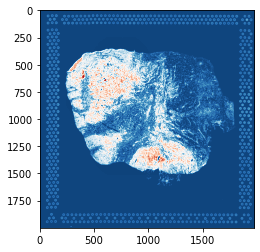

In [6]:
plt.imshow(adata_image,cmap='RdBu_r')

## Load gene signature

In [7]:
# load signature data [type x gene]
gene_sig = pd.read_csv(os.path.join(root_dir,sig_file_name))

## get gsva

In [8]:
# run gsva , gsva is based on the signature gene
run_gsva = False

if run_gsva:
    gsva_score = get_gsva.get_gsva(sample_id, var_file_name, sig_file_name)
    gsva_score.to_csv(gsva_save_path)
else:
    gsva_score = pd.read_csv(gsva_file_name,index_col=0)

(array([3., 5., 2., 4., 4., 6., 0., 0., 1., 1.]),
 array([-0.36877507, -0.24788073, -0.12698638, -0.00609203,  0.11480232,
         0.23569667,  0.35659102,  0.47748537,  0.59837972,  0.71927407,
         0.84016842]),
 <BarContainer object of 10 artists>)

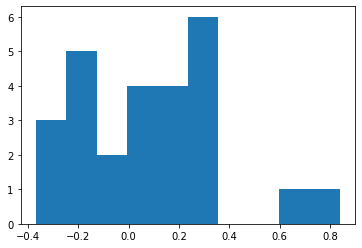

In [9]:
plt.hist(gsva_score.iloc[2,:])

In [10]:
gsva_score_discretized = utils.discretize_gsva(gsva_score)

In [11]:
gsva_score_discretized

,T_cells_c0_CD4+_CCR7,T_cells_c1_CD4+_IL7R,T_cells_c3_CD4+_Tfh_CXCL13,T_cells_c2_CD4+_T-regs_FOXP3,B_cells_Memory,B_cells_Naive,NK,Macrophage_M1,Macrophage_M2,Endothelial,...,cDC,pDC,Terminal_exhaustion,Precursor_exhaustion,CAFs_MSC_iCAF-like,CAFs_myCAF-like,PVL_Differentiated,PVL_Immature,Normal_epithelial,Plasmablasts
AAACAAGTATCTCCCA-1,1,1,1,0,1,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
AAACAGAGCGACTCCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
AAACCGGGTAGGTACC-1,1,0,0,0,1,1,0,1,1,1,...,0,0,1,1,1,1,0,1,0,0
AAACCGTTCGTCCAGG-1,1,0,1,0,0,0,0,1,0,0,...,0,1,1,1,1,1,0,1,1,0
AAACCTCATGAAGTTG-1,0,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1,0,0,0,0,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
TTGTTAGCAAATTCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTGTTCAGTGTGCTAC-1,0,1,1,1,0,0,0,0,0,1,...,0,1,0,0,1,1,1,1,0,0
TTGTTGTGTGTCAAGA-1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


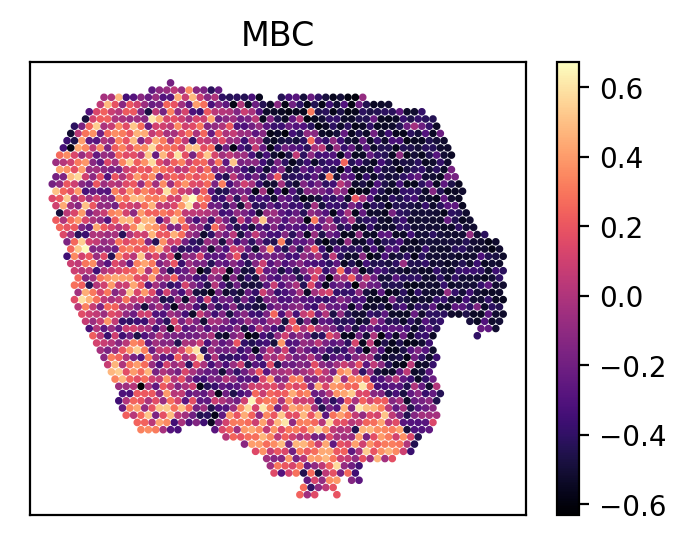

In [86]:
idx=11
pl_spatial_latent(adata_sample,map_info,gsva_score,idx,s=3,plt_title=gsva_score.columns[idx])

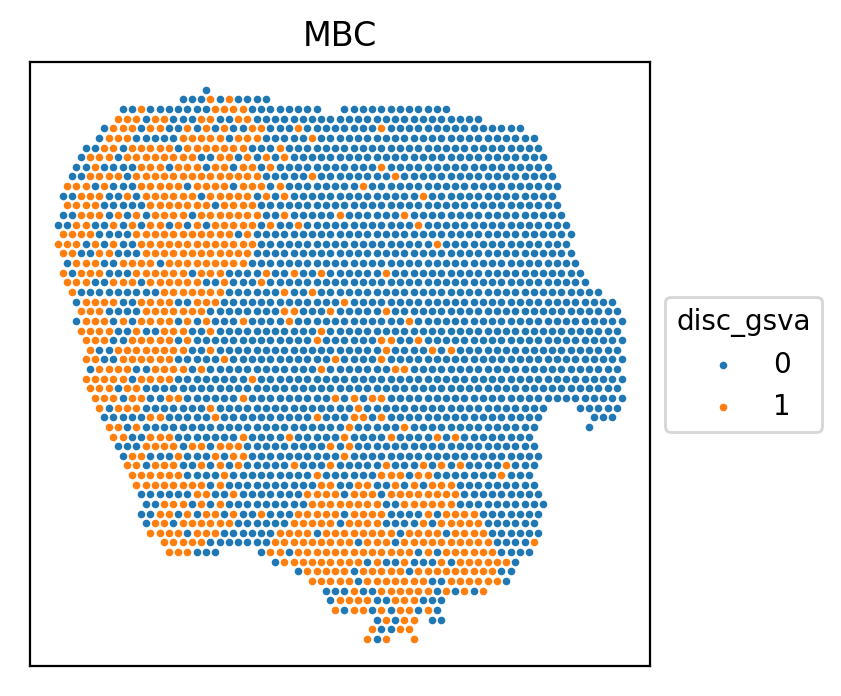

In [12]:
plot_utils.pl_spatial_gsva(adata_sample,map_info,gsva_score_discretized,11,s=3)

In [13]:
adata_sample, pure_spots, perif_spots = utils.find_spots(adata_sample, gsva_score, n_nbrs=20)

## Clustering

In [14]:
# Manifold Embedding 
sc.pp.pca(adata_sample)
sc.pp.neighbors(adata_sample)
sc.tl.umap(adata_sample, n_components=3)
sc.tl.leiden(adata_sample, key_added="clusters")

/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'pure_val' as categorical
/usr/local/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Catego

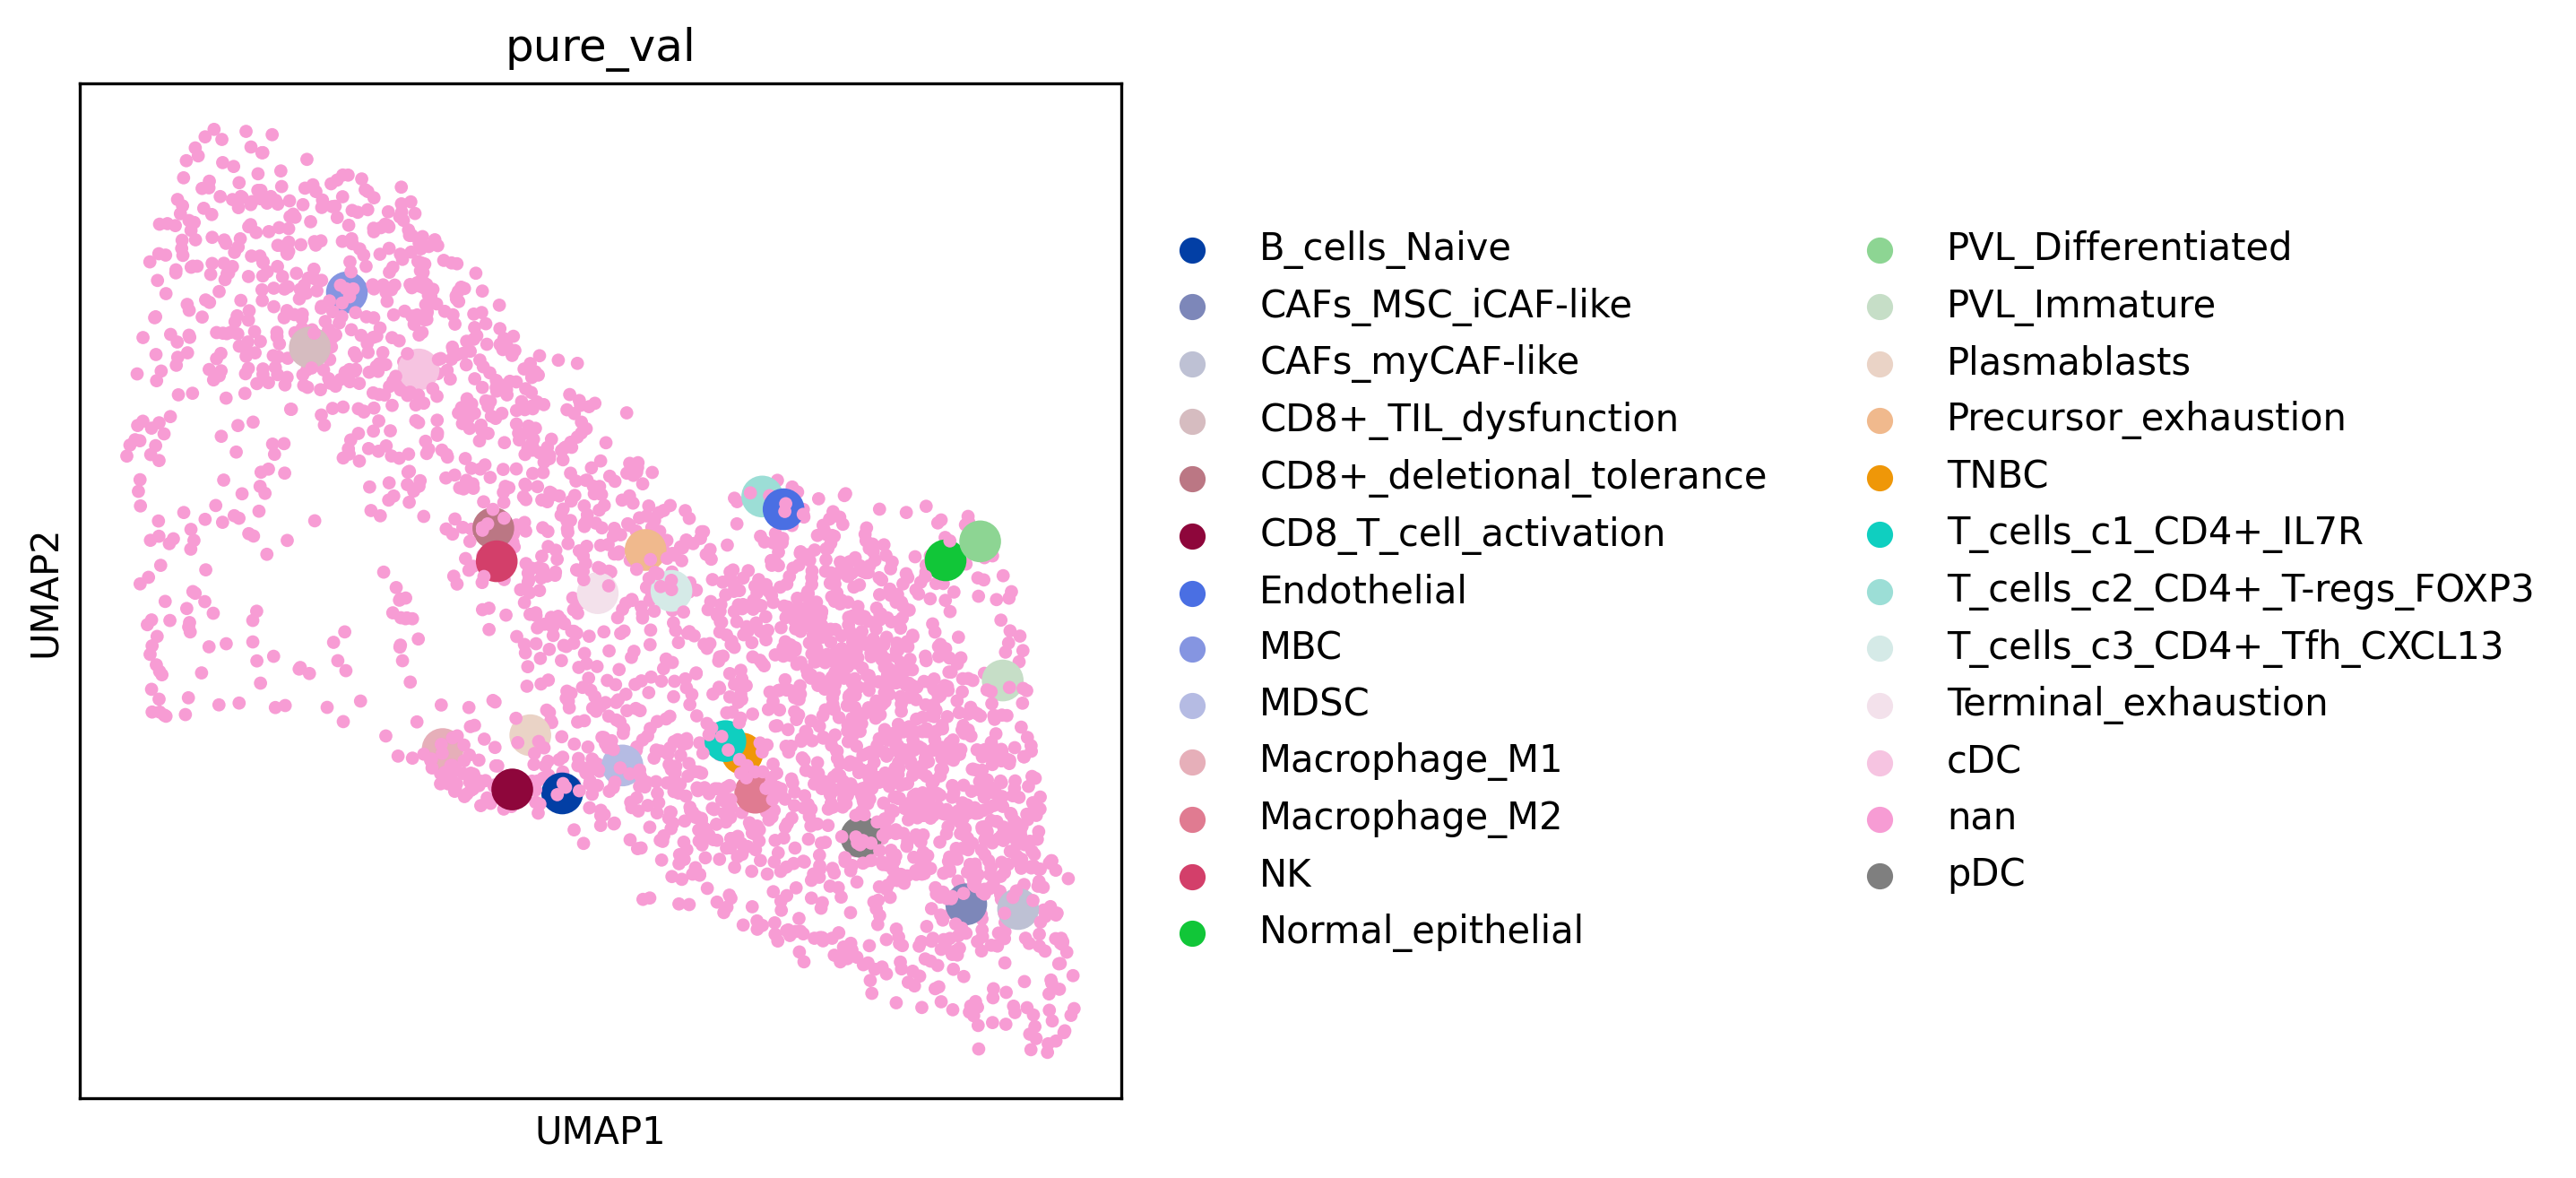

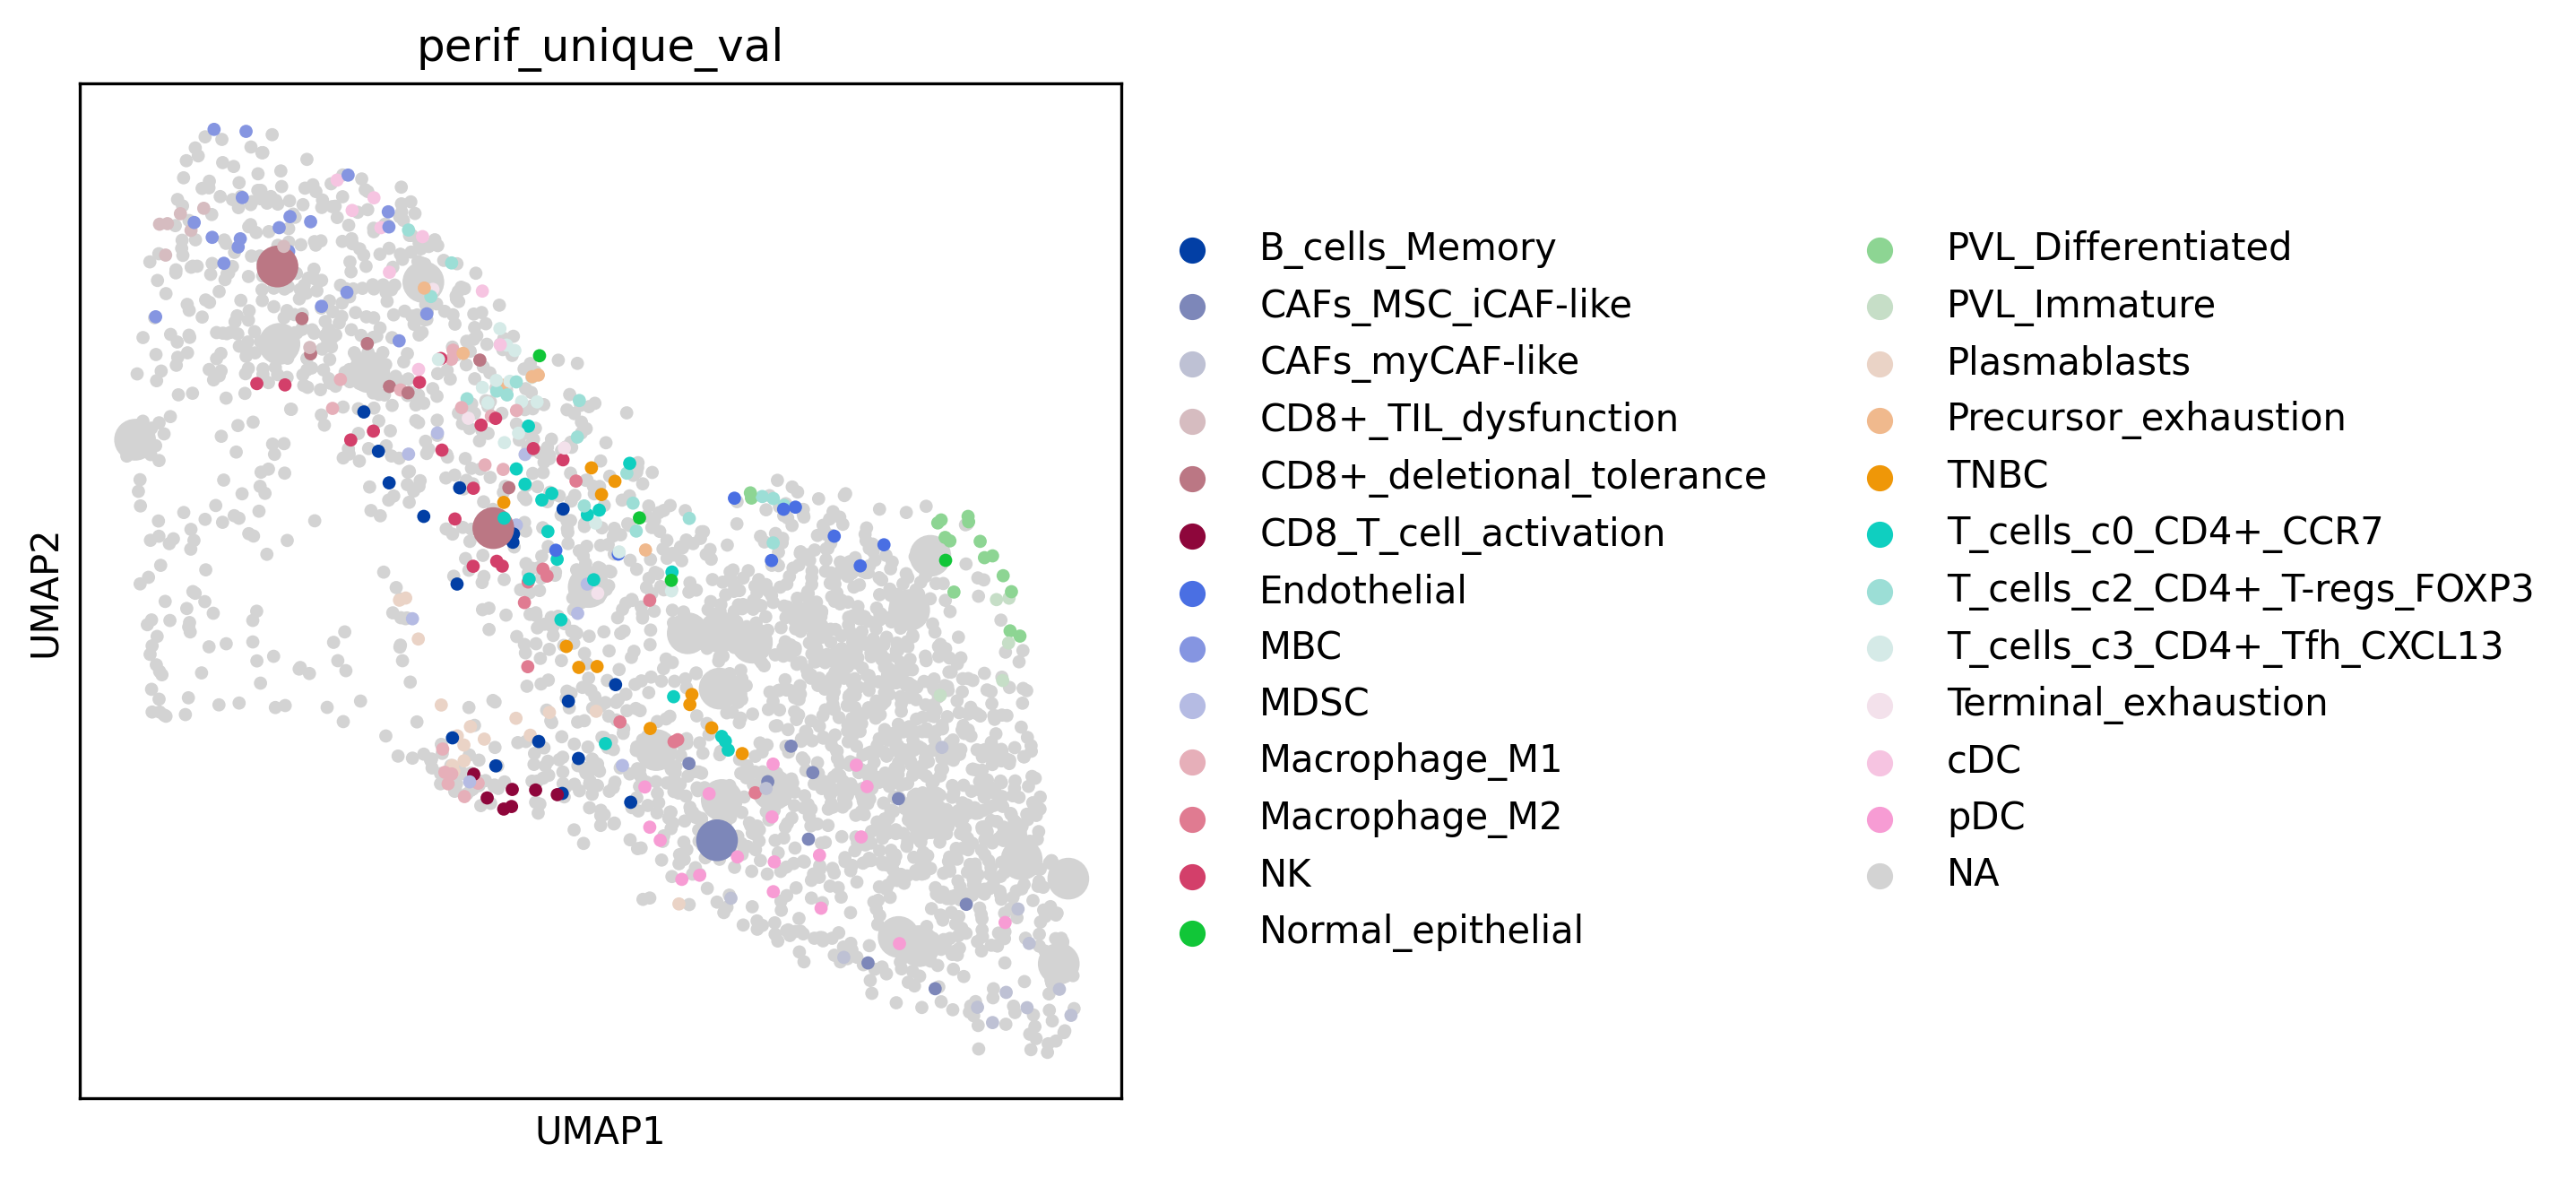

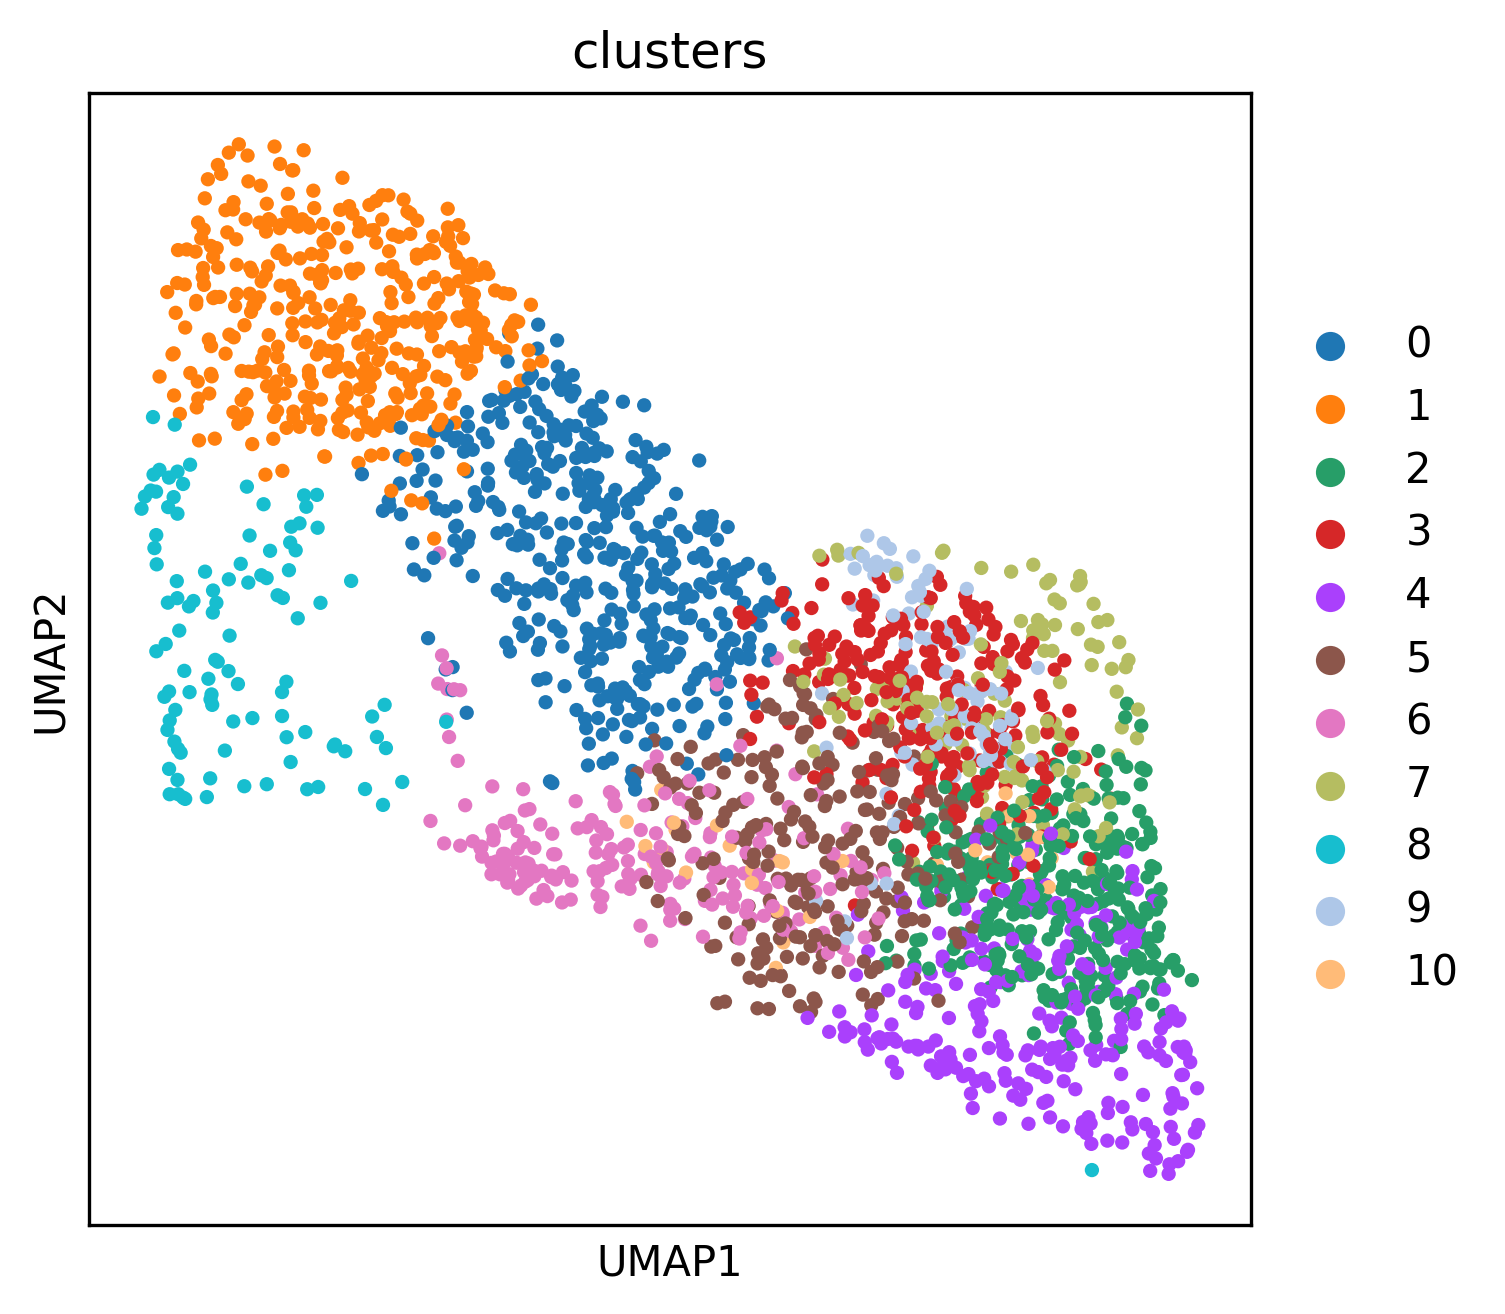

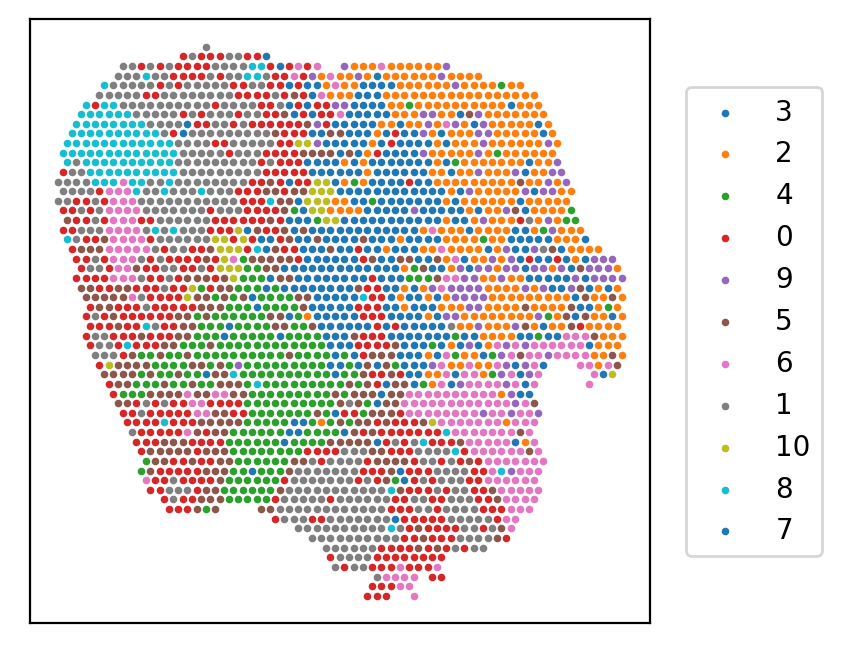

In [15]:
spot_size = adata_sample.obs_names.map(lambda x: 500 if x in set(pure_spots) else 50)
with rc_context({'figure.figsize': (5, 5),'figure.dpi':300}):
    sc.pl.umap(adata_sample, color='pure_val', size=spot_size)
    sc.pl.umap(adata_sample, color='perif_unique_val', size=spot_size)
    sc.pl.umap(adata_sample, color='clusters')
    plot_utils.pl_spatial_cluster(adata_sample,map_info,s=5)

## Generative model

In [16]:
import torch.nn as nn
class semiGe_VAE(nn.Module):
    """ SignatureVAE with generative designs"""
    
    def __init__(self,
                 adata,
                 gene_sig,
                 gsva_score_discretized
    ) -> None:
        """
        Parameters
        ----------
        c_in : int
            Num. input features (# input genes)
        c_bn : int
            Num. bottle-neck features
        
        n_gene: int = 0,
                 n_k: int = 12,
                 n_spot: float =1.0, ## label
                 n_hidden: int = 128,
                 n_latent: int = 10,
                 dropout_rate: float = 0.1,  
                 
        """
        super(semiGe_VAE, self).__init__()
        self.c_in = adata.shape[1] # c_in : Num. input features (# input genes)
        self.c_bn = gene_sig.shape[1] # c_bn : latent number, numbers of bottle neck
        self.c_hidden = 128
        
        self.z_enc = nn.Sequential(
                                nn.Linear(self.c_in, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
        )
        self.z_enc_mu = nn.Linear(self.c_hidden, self.c_bn)
        self.z_enc_var = nn.Linear(self.c_hidden, self.c_bn)
        
        self.l_enc = nn.Sequential(
                                nn.Linear(self.c_in, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
        )
        self.l_enc_mu = nn.Linear(self.c_hidden, 1)
        self.l_enc_var = nn.Linear(self.c_hidden, 1)
        
        self.c_enc = nn.Sequential(
                                nn.Linear(self.c_bn, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
        )
        self.c_enc_mu = nn.Linear(self.c_hidden, self.c_bn)
        
        self.phidden_decoder = nn.Sequential(
                                nn.Linear(self.c_bn, self.c_hidden, bias=True),
                                nn.BatchNorm1d(self.c_hidden, momentum=0.01,eps=0.001),
                                nn.ReLU(),
                                
        )
        self.px_scale_decoder = nn.Sequential(nn.Linear(self.c_hidden,self.c_in),nn.Softmax(dim=-1))
        self.px_r_decoder = nn.Linear(self.c_hidden,self.c_in)
    
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def inference(self,
                  x
                 ):
        
        hidden = self.z_enc(x)
        qz_mu = self.z_enc_mu(hidden)
        qz_var = torch.sqrt(torch.exp(self.z_enc_var(hidden))+1e-8)
        qz = self.reparameterize(qz_mu, qz_var)
        
        hidden = self.c_enc(qz)
        qc= self.c_enc_mu(hidden)
        
        hidden = self.l_enc(x)
        ql_mu = self.l_enc_mu(hidden)
        ql_var = torch.sqrt(torch.exp(self.l_enc_var(hidden))+1e-8)
        ql = self.reparameterize(ql_mu, ql_var)
        
        return dict(qz_mu=qz_mu,
                    qz_var = qz_var,
                    qz=qz,
                    ql_mu=ql_mu,
                    ql_var=ql_var,
                    ql=ql,
                    qc=qc
                   )
    
    def generative(self,
                   inference_outputs
                  ):
        z = inference_outputs['qz']
        l = inference_outputs['ql']
        #print('z=',z.shape)
        #print('l=',l.shape)
        px = self.phidden_decoder(z)
        #print('px=',px.shape)
 
        px_scale = self.px_scale_decoder(px)#.view([self.c_in,1])
        #print('px_scale=',px_scale.shape)
        px_rate = torch.exp(l)*px_scale#.view([z.shape[0],1])
        #print('px_rate=',px_rate.shape)
        px_r = torch.exp(self.px_r_decoder(px))#.view([z.shape[0],self.n_gene,self.n_k])
        #print('px_r=',px_r.shape)
        
        return dict(px_r=px_r, 
                    px_scale=px_scale,
                    px_rate=px_rate, 
                   )

In [17]:
# Reference:
# https://github.com/YosefLab/scvi-tools/blob/master/scvi/distributions/_negative_binomial.py
from torch.distributions import kl_divergence, Distribution
class NegBinom(Distribution):
    """
    Gamma-Poisson mixture approximation of Negative Binomial(mean, dispersion)

    lambda ~ Gamma(mu, theta)
    x ~ Poisson(lambda)
    """

    def __init__(self, mu, theta, eps=1e-5):
        """
        Parameters
        ----------
        mu : torch.Tensor
            mean of NegBinom. distribution
            shape - [# genes,]

        theta : torch.Tensor
            dispersion of NegBinom. distribution
            shape - [# genes,]
        """
        super(NegBinom, self).__init__()
        assert (mu > 0).sum() and (theta > 0).sum(), \
            "Negative mean / dispersion of Negative detected"

        self.mu = mu
        self.theta = theta
        self.eps = eps

    def sample(self):
        lambdas = Gamma(
            concentration=self.theta,
            rate=self.theta / self.mu,
        ).rsample()

        x = Poisson(lambdas).sample()

        return x

    def log_prob(self, x):
        """log-likelihood"""
        ll = torch.lgamma(x + self.theta) - \
             torch.lgamma(x + 1) - \
             torch.lgamma(self.theta) + \
             self.theta * (torch.log(self.theta + self.eps) - torch.log(self.theta + self.mu + self.eps)) + \
             x * (torch.log(self.mu + self.eps) - torch.log(self.theta + self.mu + self.eps))

        return ll

In [18]:
def get_loss(
            generative_outputs,
            inference_outputs,
            local_l_m,
            local_l_v,
            x
        ):
    px_r = generative_outputs["px_r"]
    #print('px_r=',px_r)
    px_rate = generative_outputs["px_rate"]
    #print('px_rate=',px_rate)
    qz_mu = inference_outputs["qz_mu"]
    #print('qz_mu=',qz_mu)
    qz_var = inference_outputs["qz_var"]
    #print('qz_var=',qz_var)
    qz = inference_outputs["qz"]
    #print('qz=',qz)
    
    ql_mu = inference_outputs["ql_mu"]
    ql_var = inference_outputs["ql_var"]
    
    

    reconst_loss = - NegBinom(mu=px_rate, theta=px_r).log_prob(x).sum(dim=-1)
            
    
    # KL divergence
    mean_z = torch.zeros_like(qz_mu)
    var_z = torch.ones_like(qz_var)
    
    #print('Normal(qz_mu, qz_var)=',Normal(qz_mu, qz_var))
    
    kl_divergence_z = kl(Normal(qz_mu, qz_var), Normal(mean_z, var_z)).sum(dim=1)
    
    kl_divergence_l = kl(Normal(ql_mu, ql_var),Normal(local_l_m, local_l_v)).sum(dim=1)
    
    loss_z = Normal(qz_mu, qz_var).log_prob(qz).sum(dim=-1)
    
    kl_weight = 1.0
    class_loss = 1.0
    class_weight = 1.0
    
    loss = reconst_loss + kl_divergence_l+kl_divergence_z* kl_weight + class_loss*class_weight
    #print('reconst_loss=',reconst_loss)
    #print('kl_divergence_l=',kl_divergence_l)
    #print('kl_divergence_z=',kl_divergence_z)
    return loss.mean(), reconst_loss.mean(),kl_divergence_l.mean(),kl_divergence_z.mean()
    

In [19]:
from tqdm import tqdm
from torch.distributions import Normal, kl_divergence as kl
def train(
            model,
            dataloader,
            dataset,
            device,
            optimizer,
        ):
    model.train()
    
    running_loss = 0.0
    counter = 0
    
    for i, x in tqdm(enumerate(dataloader),total = int(len(dataset)/dataloader.batch_size)):
        counter +=1
        x = x.float()
        x = x.to(device)
        
        local_l_m = torch.ones(len(x)) * torch.log(torch.sum(x,axis=1)).mean()
        local_l_v = torch.ones(len(x)) * torch.log(torch.sum(x,axis=1)).var()                       
        
        inference_outputs =  model.inference(x)
        generative_outputs = model.generative(inference_outputs)
        
        #print('qz=',inference_outputs['qz'].shape)
        #print('qc=',inference_outputs['qc'].shape)
        loss,reconst_loss,kl_divergence_l,kl_divergence_z = get_loss(generative_outputs,
                        inference_outputs,
                        local_l_m,
                        local_l_v,
                        x
                       )
        #print('loss=',loss)
        #print('reconst_loss=',reconst_loss)
        #print('kl_divergence_l=',kl_divergence_l)
        #print('kl_divergence_z=',kl_divergence_z)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter
    return train_loss

In [20]:
model = semiGe_VAE(
            adata = adata_sample,
            gene_sig = gene_sig,
            gsva_score_discretized = gsva_score_discretized
          )

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr=0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

In [22]:
trainset = utils.VisiumDataset(adata=adata_sample)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

In [23]:
epochs= 6
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, trainloader, trainset, device, optimizer)
    train_loss.append(train_epoch_loss)
    torch.cuda.empty_cache()
    print(f"Train Loss: {train_epoch_loss:.4f}")
print('finish lower training rate')

Epoch 1 of 6


  0%|                                                    | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class '__main__.NegBinom'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +
20it [00:10,  1.98it/s]                                                         


Train Loss: 434606.0852
Epoch 2 of 6


20it [00:09,  2.02it/s]                                                         


Train Loss: 295942.8898
Epoch 3 of 6


20it [00:09,  2.12it/s]                                                         


Train Loss: 175200.0189
Epoch 4 of 6


20it [00:08,  2.44it/s]                                                         


Train Loss: 70167.9177
Epoch 5 of 6


20it [00:08,  2.47it/s]                                                         


Train Loss: 40330.4907
Epoch 6 of 6


20it [00:08,  2.44it/s]                                                         

Train Loss: 68908.6189
finish lower training rate


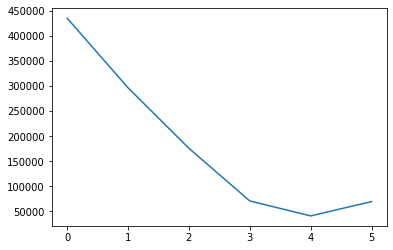

In [24]:
plt.plot(train_loss)

In [25]:
inference_outputs =  model.inference(torch.Tensor(np.array(adata_sample.to_df())))
generative_outputs = model.generative(inference_outputs)

In [26]:
inference_outputs.keys()

dict_keys(['qz_mu', 'qz_var', 'qz', 'ql_mu', 'ql_var', 'ql', 'qc'])

In [27]:
qz = inference_outputs['qz']
qz_df = pd.DataFrame(qz.detach().numpy(),index = adata_sample.to_df().index, columns= gsva_score_discretized.columns)
ql = inference_outputs['ql']
ql_df = pd.DataFrame(ql.detach().numpy(),index = adata_sample.to_df().index)
qc = inference_outputs['qc']
qc_df = pd.DataFrame(qc.detach().numpy(),index = adata_sample.to_df().index, columns= gsva_score_discretized.columns)

In [41]:
def pl_spatial_latent(adata_sample,
               map_info,
               color_mtx,
               idx,
               plt_title,
               vmin=None,
               vmax=None,
               s=3,
              ):
    
    color_idx_list = list(color_mtx.iloc[:,idx].astype(float))
    all_loc = np.array(map_info.loc[:,['array_col','array_row']])
    fig,axs= plt.subplots(1,1,figsize=(4,3),dpi=200)
    g=axs.scatter(all_loc[:,0],-all_loc[:,1],cmap='magma',c=color_idx_list,s=3,vmin=vmin,vmax=vmax)

    #plt.legend(color_unique_idx,title='disc_gsva',loc='right',bbox_to_anchor=(1.3, 0.5))
    fig.colorbar(g)
    plt.title(plt_title)
    axs.set_xticks([])
    axs.set_yticks([])
    
    pass

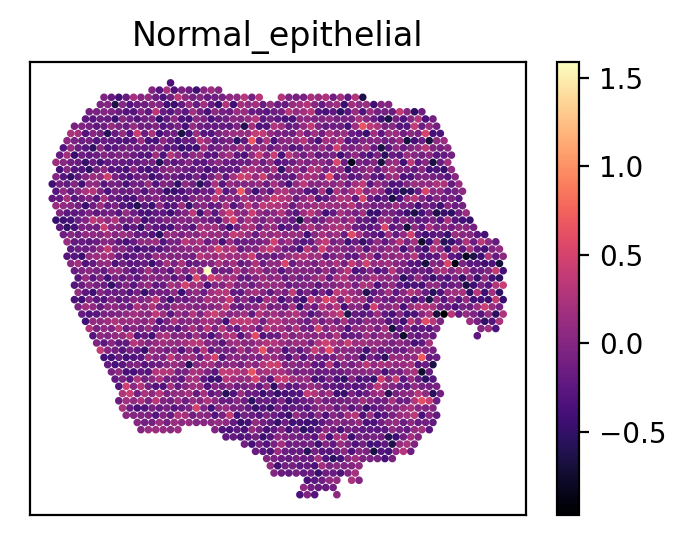

In [76]:
idx = 24
pl_spatial_latent(adata_sample,map_info,qc_df,idx,plt_title=qz_df.columns[idx],s=3)

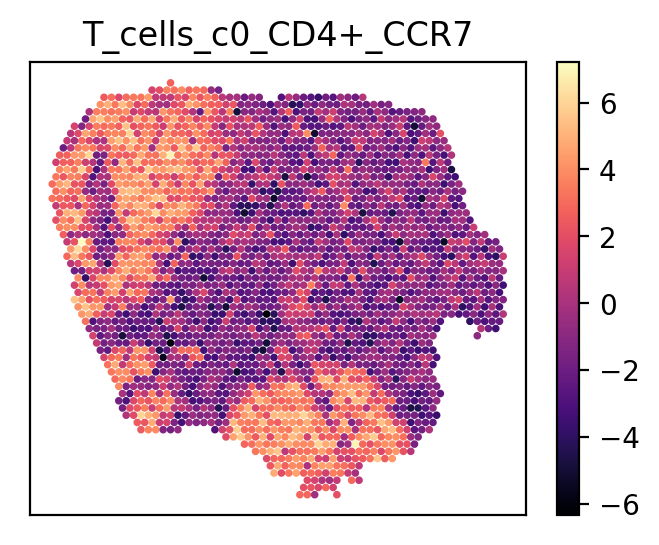

In [68]:
idx = 0
pl_spatial_latent(adata_sample,map_info,qz_df,idx,plt_title=qz_df.columns[idx],s=3)

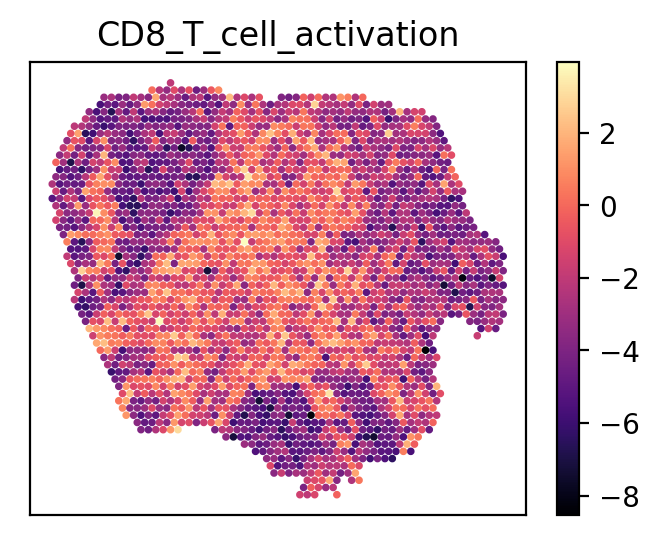

In [65]:
idx = 13
pl_spatial_latent(adata_sample,map_info,qz_df,idx,plt_title=qz_df.columns[idx],s=3)

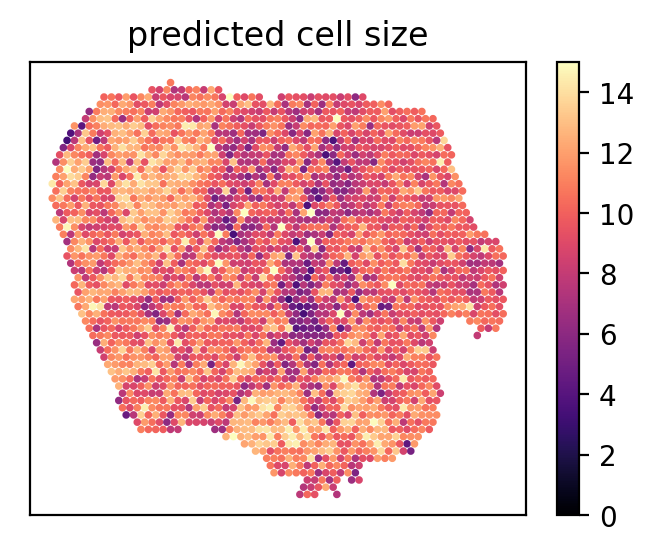

In [66]:
pl_spatial_latent(adata_sample,
                  map_info,
                  ql_df,
                  0,
                  plt_title='predicted cell size',
                  vmin=0,
                  vmax=15,
                  s=3)